<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/TP2/7506R_TP2_GRUPO2_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2: Críticas cinematográficas</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


# Importación de librerias

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Tokens y preprocesamiento
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Modelos
import joblib
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

RAND_SEED = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Lectura de archivo


### Desde google drive

In [2]:
drive.mount('/content/drive')
root_path = "/content/drive/MyDrive/7506R-1C2024-GRUPO02/TP2/"

Mounted at /content/drive


### Desde maquina local

In [ ]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# root_path = "./"

In [3]:
train_path = root_path + 'Dataset/train.csv'
test_path = root_path + 'Dataset/test.csv'
sample_path = root_path + 'Dataset/sample_solution.csv'
ds_train = pd.read_csv(train_path)
ds_test = pd.read_csv(test_path)
sample = pd.read_csv(sample_path)

# Visualizamos los datasets

In [4]:
ds_train.info()
ds_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


In [5]:
ds_train

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...,...
49995,49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,49998,Voy a tener que estar en desacuerdo con el com...,negativo


Dividimos el dataset de train en x_train e y_train (la primera tendra el texto y la segunda las labels).

Adicionalmente no incluiremos la columna ID ya que no es necesaria para nuestro proposito de entrenamiento.

In [6]:
def map_sentiment(ds, invert=False):
  return ds.map({'negativo': 0, 'positivo': 1}) if not invert else ds.map({0: 'negativo', 1: 'positivo'})

In [7]:
x_train_text_completo = ds_train["review_es"]
y_train_completo = map_sentiment(ds_train["sentimiento"])

In [8]:
ds_test

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


Creamos el dataset de x_test sin incluir el id

In [9]:
x_test_text = ds_test["review_es"]

# Preprocesamiento

## Division de train y validation

Dividimos el training set en training y validating sets

In [10]:
x_train_text, x_validation_text, y_train, y_validation = train_test_split(
    ds_train['review_es'], ds_train["sentimiento"],
    stratify=ds_train["sentimiento"],
    test_size=0.20,
    random_state=RAND_SEED
    )

In [11]:
y_train = map_sentiment(y_train)

## Normalizacion

### Tokenizacion

In [12]:
def clean_text(text):
  return text.strip()

In [13]:
def tokenizer(text):
  return [w for w in word_tokenize(text) if w.isalpha()]

tokenizer(clean_text(x_train_text.iloc[1]))[:10]

['No',
 'puedo',
 'creer',
 'que',
 'me',
 'permita',
 'a',
 'esta',
 'película',
 'para']

Defino un stop list de palabras en español

In [14]:
stoplist = stopwords.words("spanish")
stoplist[:15]

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con']

Tokenizamos las stopwords con el mismo tokenizador que utilizamos en el corpus

In [ ]:
stoplist_tokenized = []

for w in stoplist:
    stoplist_tokenized = stoplist_tokenized + tokenizer(w)

stoplist_tokenized = list(set(stoplist_tokenized)) # sin repedidos

### Stem - Lematizacion

Visualizamos qué tipo de palabras tenemos en train

In [ ]:
postags = pos_tag(word_tokenize(clean_text(x_train_text.iloc[1])))
postags[:10]

[('No', 'DT'),
 ('puedo', 'NN'),
 ('creer', 'NN'),
 ('que', 'IN'),
 ('me', 'PRP'),
 ('permita', 'VBP'),
 ('a', 'DT'),
 ('esta', 'JJ'),
 ('película', 'NN'),
 ('para', 'NN')]

Podemos ver que nos encontramos con palabras como adverbios, verbos, preposiciones, adjetivos, pronombres, sustantivos, etc.

Instanciamos un lemmatizador

In [ ]:
wnl = WordNetLemmatizer()

Generamos la función de lematización por pos



In [ ]:
def word_pos_to_lemma(word, pos, wnl):
    if pos.startswith('J'):
        return wnl.lemmatize(word,wordnet.ADJ) # adjetivo
    elif pos.startswith('V'):
        return wnl.lemmatize(word,wordnet.VERB) # vervo
    elif pos.startswith('N'):
        return wnl.lemmatize(word,wordnet.NOUN)# sustantivo
    elif pos.startswith('R'):
        return wnl.lemmatize(word,wordnet.ADV) # advervio
    else:
        return wnl.lemmatize(word)

In [ ]:
lemmatized_words = [(w, word_pos_to_lemma(w, pos, wnl)) for w, pos in postags if w.isalpha()]
lemmatized_words[:10]

[('No', 'No'),
 ('puedo', 'puedo'),
 ('creer', 'creer'),
 ('que', 'que'),
 ('me', 'me'),
 ('permita', 'permita'),
 ('a', 'a'),
 ('esta', 'esta'),
 ('película', 'película'),
 ('para', 'para')]

In [ ]:
# Usar Counter para contar las repeticiones de cada tupla
lemmatized_counter = Counter(lemmatized_words)

# Imprimir los resultados
list(lemmatized_counter.items())[:10]

[(('No', 'No'), 1),
 (('puedo', 'puedo'), 1),
 (('creer', 'creer'), 1),
 (('que', 'que'), 4),
 (('me', 'me'), 3),
 (('permita', 'permita'), 1),
 (('a', 'a'), 8),
 (('esta', 'esta'), 2),
 (('película', 'película'), 3),
 (('para', 'para'), 4)]

Podemos ver que las lematizaciones se aplican más de una vez

In [ ]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.isalpha()]
    return lemmatized_words

In [ ]:
lemmatize_text(clean_text(x_train_text.iloc[1]))[:10]

['No',
 'puedo',
 'creer',
 'que',
 'me',
 'permita',
 'a',
 'esta',
 'película',
 'para']

## Vectorizacion

### Bag of words

Con tokenizacion sin lemmas

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=5,
                             stop_words=stoplist_tokenized)
x_train_bow_tok = count_vect.fit_transform(x_train_text) # cuenta frecuencia de tokens y define el diccionario
x_validation_bow_tok = count_vect.transform(x_validation_text) # cuenta frecuencia de tokens existentes en el diccionario
x_train_bow_tok

<40000x48415 sparse matrix of type '<class 'numpy.int64'>'
	with 3999252 stored elements in Compressed Sparse Row format>

Con tokenizacion con lemmas

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=lemmatize_text,
                             min_df=5,
                             stop_words=lemmatized_words)
x_train_bow_lemma = count_vect.fit_transform(x_train_text) # cuenta frecuencia de tokens y define el diccionario
x_validation_bow_lemma = count_vect.transform(x_validation_text) # cuenta frecuencia de tokens existentes en el diccionario
x_train_bow_lemma

<40000x47766 sparse matrix of type '<class 'numpy.int64'>'
	with 5308134 stored elements in Compressed Sparse Row format>

### N-gramas

Con tokenizacion sin lemmas

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=5,
                             stop_words=stoplist_tokenized,
                             ngram_range=(1,2))
x_train_ngram_tok = count_vect.fit_transform(x_train_text) # cuenta frecuencia de tokens y define el diccionario
x_validation_ngram_tok = count_vect.transform(x_validation_text) # cuenta frecuencia de tokens existentes en el diccionario
x_train_ngram_tok

<40000x152699 sparse matrix of type '<class 'numpy.int64'>'
	with 5610823 stored elements in Compressed Sparse Row format>

Con tokenizacion con lemmas

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=lemmatize_text,
                             min_df=5,
                             stop_words=lemmatized_words,
                             ngram_range=(1,2))
x_train_ngram_lemma = count_vect.fit_transform(x_train_text) # cuenta frecuencia de tokens y define el diccionario
x_validation_ngram_lemma = count_vect.transform(x_validation_text) # cuenta frecuencia de tokens existentes en el diccionario
x_train_ngram_lemma

<40000x231974 sparse matrix of type '<class 'numpy.int64'>'
	with 11406128 stored elements in Compressed Sparse Row format>

### TF-IDF

Con tokenizacion sin lemmas

In [ ]:
tfidf_vect = TfidfVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=5,
    stop_words=stoplist_tokenized
)
x_train_tfidf_tok = tfidf_vect.fit_transform(x_train_text) # cuenta frecuencia de tokens y define el diccionario
x_validation_tfidf_tok = tfidf_vect.transform(x_validation_text) # cuenta frecuencia de tokens existentes en el diccionario
x_train_tfidf_tok

<40000x48415 sparse matrix of type '<class 'numpy.float64'>'
	with 3999252 stored elements in Compressed Sparse Row format>

Con tokenizacion con lemmas

In [ ]:
tfidf_vect = TfidfVectorizer(
    preprocessor=clean_text,
    tokenizer=lemmatize_text,
    min_df=5,
    stop_words=lemmatized_words
)
x_train_tfidf_lemma = tfidf_vect.fit_transform(x_train_text)
x_validation_tfidf_lemma = tfidf_vect.transform(x_validation_text)
x_train_tfidf_lemma

<40000x47766 sparse matrix of type '<class 'numpy.float64'>'
	with 5308134 stored elements in Compressed Sparse Row format>

### Utils

Creacion de algunas funciones de utilidad

In [ ]:
def plot_confussion_matrix(true, pred):
  #Creo matriz de confusión
  tabla = confusion_matrix(true, pred)

  #Grafico matriz de confusión
  sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicciones')
  plt.ylabel('Verdaderos')

  #Reporte
  print(classification_report(true, pred))

In [ ]:
def build_results(pred):
  res = ds_test.copy()
  res.drop(columns=["review_es"], inplace=True)
  res['sentimiento'] = pred
  return res

In [ ]:
def print_positive_negatives(sentimientos):
  total_positives = (sentimientos == "positivo").sum()
  total_negatives = (sentimientos == "negativo").sum()
  print(f"Positives: {total_positives}\nNegatives: {total_negatives}")

# Random Forest

## Modelos

Entrenamiento de random forest sin hiper-parametros

In [ ]:
rf = RandomForestClassifier(random_state=RAND_SEED) # entreno
rf = rf.fit(x_train_ngram_tok, y_train) # predigo

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['negativo' 'positivo'] and y_pred=[0 1]. Make sure that the predictions provided by the classifier coincides with the true labels.

              precision    recall  f1-score   support

    negativo       0.83      0.84      0.84      5000
    positivo       0.84      0.83      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



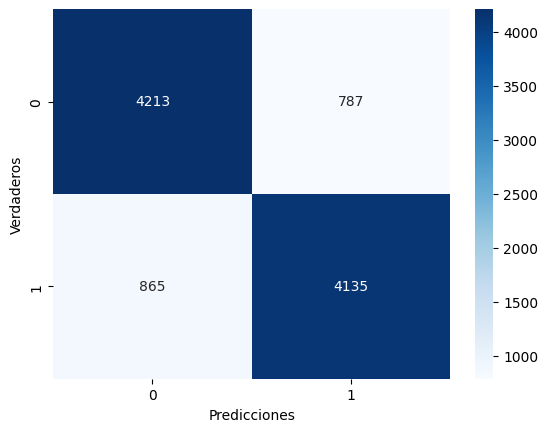

In [ ]:
y_pred = rf.predict(x_validation_ngram_tok)
y_pred = map_sentiment(pd.Series(y_pred), invert=True)
plot_confussion_matrix(y_validation, y_pred) # grafico

Buscamos los mejores hiper parametros haciendo cross validation usando como dataset el seleccionado mejor en la anterior seccion, es decir el training set de N-gramas con tokenizacion sin lemmas.

In [ ]:
kfoldcv = KFold(n_splits=5)
scorer_fn = make_scorer(f1_score, average='macro')
n = 50

rf_model = RandomForestClassifier(oob_score=True, random_state=RAND_SEED, n_jobs=-1)

params_grid = {
    'max_depth': list(range(2,6)),
    'criterion':["gini", "entropy"],
    'min_samples_split': list(range(2,10)),
    'min_samples_leaf': list(range(1,10)),
    'n_estimators': list(range(100, 400, 100)),
    }

rs = RandomizedSearchCV(estimator=rf_model, param_distributions=params_grid, scoring=scorer_fn, cv=kfoldcv, n_iter=n, n_jobs=-1)
rs_fit = rs.fit(X = x_train_ngram_tok, y = y_train) # entrenamiento
print(rs_fit.best_score_, rs_fit.best_params_, end='\n\n')

0.7952365039157812 {'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'gini'}



In [ ]:
best_params = rs_fit.cv_results_['params'][np.argmax(rs_fit.cv_results_['mean_test_score'])]
best_params

{'n_estimators': 300,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_depth': 5,
 'criterion': 'gini'}

Fine-tunning de los params

In [ ]:
# TODO UBICAR - SOLO PROBANDO
params_grid = {
    'max_depth': [best_params['max_depth'] - 1, best_params['max_depth'], best_params['max_depth'] + 1],
    'criterion': [best_params['criterion']],
    'min_samples_split': [best_params['min_samples_split'] - 1, best_params['min_samples_split'], best_params['min_samples_split'] + 1],
    'min_samples_leaf': [best_params['min_samples_leaf']],
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50]
}

gs = GridSearchCV(estimator=rf_model, param_grid=params_grid, scoring=scorer_fn, cv=kfoldcv, n_jobs=-1)
gs_fit = gs.fit(X = x_train_ngram_tok, y = y_train) # entrenamiento
print(gs_fit.best_score_, gs_fit.best_params_, end='\n\n')

0.7990487998035642 {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 350}



Los mejores hiperparametros fueron:

In [ ]:
params_elegidos=gs_fit.cv_results_['params'][np.argmax(gs_fit.cv_results_['mean_test_score'])]
params_elegidos

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 350}

              precision    recall  f1-score   support

    negativo       0.85      0.72      0.78      5000
    positivo       0.76      0.88      0.81      5000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



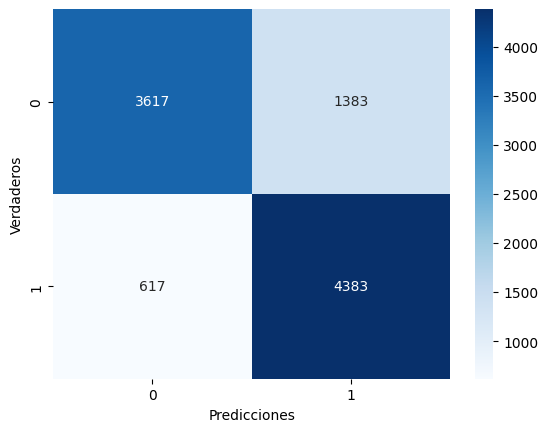

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=RAND_SEED, n_jobs=-1, **params_elegidos)
rf = rf.fit(x_train_ngram_tok, y_train)
y_pred = rf.predict(x_validation_ngram_tok)
y_pred = map_sentiment(pd.Series(y_pred), invert=True)
plot_confussion_matrix(y_validation, y_pred)

Ahora probamos el modelo con el resto de training sets para ver si alguno lo mejora.

Bag of words con tokenizacion sin lemmas

              precision    recall  f1-score   support

    negativo       0.85      0.74      0.79      5000
    positivo       0.77      0.87      0.81      5000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



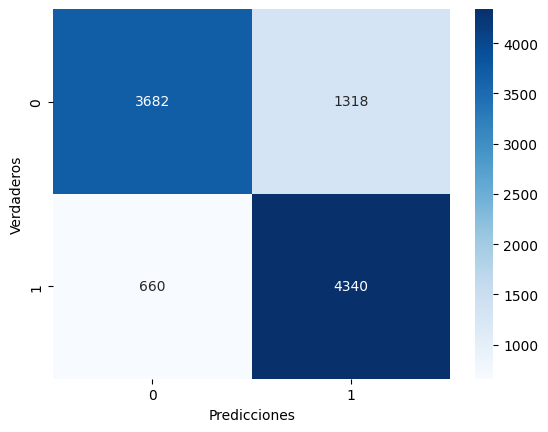

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=RAND_SEED, n_jobs=-1, **params_elegidos)
rf = rf.fit(x_train_bow_tok, y_train)
y_pred = rf.predict(x_validation_bow_tok)
y_pred = map_sentiment(pd.Series(y_pred), invert=True)
plot_confussion_matrix(y_validation, y_pred)

Bag of words con tokenizacion con lemmas

              precision    recall  f1-score   support

    negativo       0.84      0.73      0.78      5000
    positivo       0.76      0.87      0.81      5000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



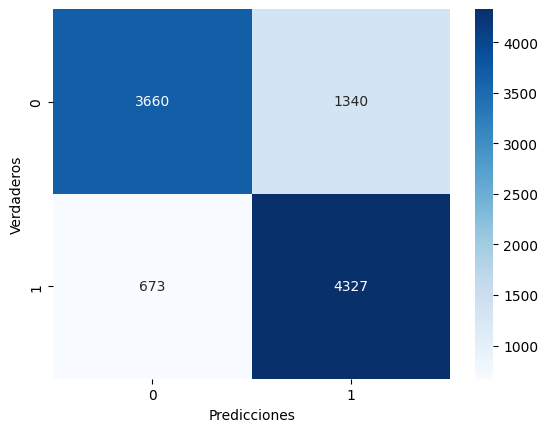

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=RAND_SEED, n_jobs=-1, **params_elegidos)
rf = rf.fit(x_train_bow_lemma, y_train)
y_pred = rf.predict(x_validation_bow_lemma)
y_pred = map_sentiment(pd.Series(y_pred), invert=True)
plot_confussion_matrix(y_validation, y_pred)

N-gramas con tokenizacion con lemmas

              precision    recall  f1-score   support

    negativo       0.86      0.73      0.79      5000
    positivo       0.77      0.88      0.82      5000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



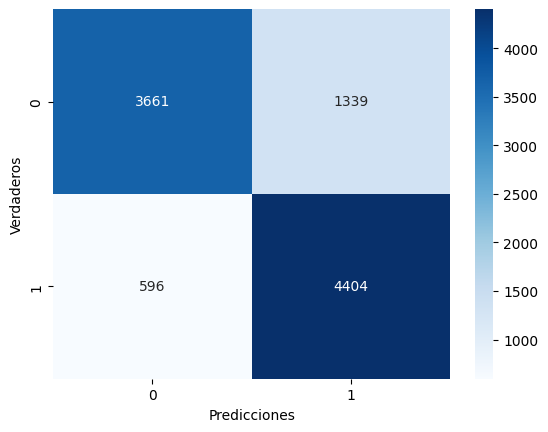

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=RAND_SEED, n_jobs=-1, **params_elegidos)
rf = rf.fit(x_train_ngram_lemma, y_train)
y_pred = rf.predict(x_validation_ngram_lemma)
y_pred = map_sentiment(pd.Series(y_pred), invert=True)
plot_confussion_matrix(y_validation, y_pred)

Tf-idf con tokenizacion sin lemmas

              precision    recall  f1-score   support

    negativo       0.84      0.74      0.79      5000
    positivo       0.77      0.86      0.81      5000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



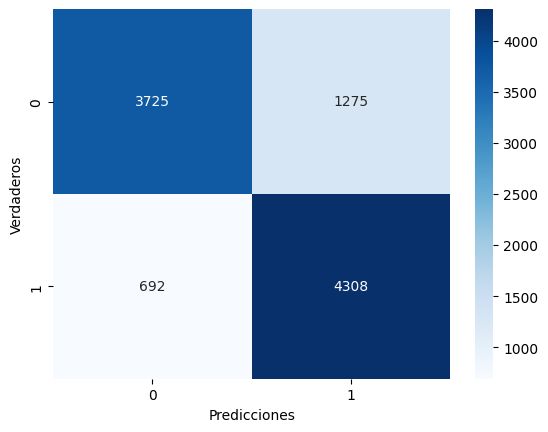

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=RAND_SEED, n_jobs=-1, **params_elegidos)
rf = rf.fit(x_train_tfidf_tok, y_train)
y_pred = rf.predict(x_validation_tfidf_tok)
y_pred = map_sentiment(pd.Series(y_pred), invert=True)
plot_confussion_matrix(y_validation, y_pred)

Tf-idf con tokenizacion con lemmas

              precision    recall  f1-score   support

    negativo       0.84      0.74      0.79      5000
    positivo       0.77      0.86      0.81      5000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



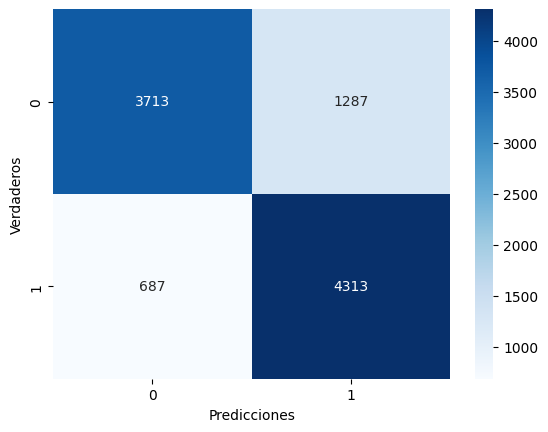

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=RAND_SEED, n_jobs=-1, **params_elegidos)
rf = rf.fit(x_train_tfidf_lemma, y_train)
y_pred = rf.predict(x_validation_tfidf_lemma)
y_pred = map_sentiment(pd.Series(y_pred), invert=True)
plot_confussion_matrix(y_validation, y_pred)

## Mejor modelo

### Refitting completo

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=lemmatize_text,
                             min_df=5,
                             stop_words=lemmatized_words,
                             ngram_range=(1,2))
x_train = count_vect.fit_transform(x_train_text_completo)
x_test = count_vect.transform(x_test_text)
x_train

<50000x277262 sparse matrix of type '<class 'numpy.int64'>'
	with 14445174 stored elements in Compressed Sparse Row format>

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=RAND_SEED, n_jobs=-1, **params_elegidos).fit(x_train, y_train_completo)
y_pred = rf.predict(x_test) # predigo en el set de testeo
y_pred = map_sentiment(pd.Series(y_pred), invert=True)

In [ ]:
resultados_random_forest = build_results(y_pred)

In [ ]:
print_positive_negatives(resultados_random_forest['sentimiento'])

Positives: 5623
Negatives: 2976


# Guardado de resultados y modelo

In [ ]:
# random forest
resultados_random_forest.to_csv(root_path + "Dataset/resultados_random_forest.csv", index=False)
joblib.dump(rf, root_path + 'Models/random_forest.pkl')


['/content/drive/MyDrive/7506R-1C2024-GRUPO02/TP2/Models/random_forest.pkl']